In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../dataset_real/gianpaolo/step_0.10/force/forward_continuous.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(55, 56, 57, 58), dtype=bool)
print("Motion data has a length of ", len(motion))

Motion data has a length of  1726


In [6]:
motion.shape

(1726, 59)

## Height-Force plots

In [7]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [8]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

### Footstep IDXs

In [9]:
footsteps_fwd = get_specific_cmd(motion, 1, 0, 0)
footsteps_clock = get_specific_cmd(motion, 0, 0, -1)
footsteps_count = get_specific_cmd(motion, 0, 0, 1)
footsteps_side_right = get_specific_cmd(motion, 0, -1, 0)
footsteps_side_left = get_specific_cmd(motion, 0, 1, 0)

# Dataset Preparation

In [10]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [11]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [12]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [14]:
def create_com_dataset(dataset, footsteps, motion=None, debug=False):
    inputs = []
    labels = []
    counter = 0
    velocityTransition = False
    
    for idx, footstep in enumerate(footsteps):
        if idx > 0:
            # Compute time difference between
            # current and next footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            if time_difference < 0.5 and (dataset[footsteps[idx-2], 1] > 0.05 or dataset[footsteps[idx-1], 1] > 0.05):
                lf_rh_moving = contacts[footsteps[idx], 0]
                rf_lh_moving = contacts[footsteps[idx], 1]
                
                if lf_rh_moving == rf_lh_moving:
                    print("Invalid")
                    continue                    
                
                # Compute rotation matrices from odometry orientation
                R_prev = quaternion_rotation_matrix(dataset[footsteps[idx-1], 48:52])
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 48:52])

                # Odom base vectors
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Rotate odometry estimation
                rotated_prev_base = prev_base @ R_prev
                rotated_curr_base = curr_base @ R_prev
                base_displacement = rotated_curr_base - rotated_prev_base
                
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 48:52])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 48:52])
                yaw = curr_yaw - prev_yaw
                
                # Handle angle wrap
                if np.sign(prev_yaw) != np.sign(curr_yaw):
                    print("Angle wrap detected.")
                    continue
                
                #print(dataset[footsteps[idx-1], 1:4], dataset[footsteps[idx], 1:4], rotated_prev_base, rotated_curr_base) 
                    
                inputs.append(dataset[footsteps[idx-2], 1:4].tolist() +
                              dataset[footsteps[idx-1], 1:16].tolist() +
                              dataset[footsteps[idx-1], 19:23].tolist() +
                              [lf_rh_moving, rf_lh_moving])
                
                # Labels
                labels.append([base_displacement[0], base_displacement[1], yaw])
                
                
    return np.array(inputs, dtype=float), np.array(labels, dtype=float)
                
X_motion_fwd_CoM, Y_motion_fwd_CoM = create_com_dataset(motion, footsteps_fwd)
#X_motion_clock_CoM, Y_motion_clock_CoM = create_com_dataset(motion, footsteps_clock)
#X_motion_count_CoM, Y_motion_count_CoM = create_com_dataset(motion, footsteps_count)
#X_motion_side_left_CoM, Y_motion_side_left_CoM = create_com_dataset(motion, footsteps_side_left)
#X_motion_side_right_CoM, Y_motion_side_right_CoM = create_com_dataset(motion, footsteps_side_right)

# Stack datasets
#X_motion_CoM_continuous = np.concatenate((X_motion_fwd_CoM, X_motion_clock_CoM, X_motion_count_CoM))
#Y_motion_CoM_continuous = np.concatenate((Y_motion_fwd_CoM, Y_motion_clock_CoM, Y_motion_count_CoM))

X_motion_CoM_continuous = X_motion_fwd_CoM
Y_motion_CoM_continuous = Y_motion_fwd_CoM

print(X_motion_CoM_continuous.shape)
print(Y_motion_CoM_continuous.shape)

(702, 24)
(702, 3)


In [15]:
%store X_motion_CoM_continuous
%store Y_motion_CoM_continuous

Stored 'X_motion_CoM_continuous' (ndarray)
Stored 'Y_motion_CoM_continuous' (ndarray)


# Velocity Check

In [16]:
set(X_motion_CoM_continuous[:, 0])

{0.001,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001}

In [17]:
idx = np.where(np.isclose(X_motion_CoM_continuous[:, 0], 0.7))[0]

In [18]:
print(np.mean(X_motion_CoM_continuous[:, 18]), np.std(X_motion_CoM_continuous[:, 18]))

0.3801001014308659 0.2201884893810284


In [36]:
print(np.mean(X_motion_CoM_continuous[:, 19]), np.std(X_motion_CoM_continuous[:, 19]))

102.45441595441595 27.384828532888424


In [37]:
print(np.mean(X_motion_CoM_continuous[:, 20]), np.std(X_motion_CoM_continuous[:, 20]))

95.4900284900285 26.415252603082532


In [38]:
print(np.mean(X_motion_CoM_continuous[:, 21]), np.std(X_motion_CoM_continuous[:, 21]))

95.98717948717949 26.500413495010427


In [29]:
for x in range(500):
    print(X_motion_CoM_continuous[x, 0], X_motion_CoM_continuous[x, 3], X_motion_CoM_continuous[x, 18:22])

0.001 0.1 [127.  61. 114. 115.]
0.1 0.1 [ 92. 120. 104.  86.]
0.1 0.1 [131.  94.  31. 117.]
0.1 0.1 [ 82. 114. 110.  93.]
0.1 0.1 [133. 109.  83. 113.]
0.1 0.1 [ 65. 113. 100.  59.]
0.1 0.1 [133.  57.  31. 115.]
0.1 0.1 [119. 121. 114.  96.]
0.1 0.1 [140. 110.  84. 115.]
0.1 0.1 [ 80. 117. 115.  88.]
0.1 0.1 [125.  50.  91.  98.]
0.1 0.1 [ 58. 117. 120.  25.]
0.1 0.1 [133.  70. 105. 111.]
0.1 0.1 [117. 124. 116.  96.]
0.1 0.1 [140.  95. 106. 116.]
0.1 0.1 [ 53. 110. 102.  61.]
0.1 0.1 [136.  66.  39. 120.]
0.1 0.1 [ 80. 118. 116.  90.]
0.1 0.1 [137.  22.  37. 117.]
0.1 0.1 [ 77. 120. 111.  86.]
0.1 0.1 [128.  74.  89. 103.]
0.1 0.1 [110. 122. 115. 107.]
0.1 0.1 [135.  97. 103. 117.]
0.1 0.1 [ 77. 113. 102.  58.]
0.1 0.1 [136.  85. 107. 118.]
0.1 0.1 [ 81. 117. 113.  95.]
0.1 0.1 [138.  44.  23. 119.]
0.1 0.1 [ 99. 122. 117. 109.]
0.1 0.1 [130.  92.  83. 110.]
0.1 0.1 [102. 119. 116.  95.]
0.1 0.1 [133.  89. 109. 113.]
0.1 0.1 [ 67. 112.  92.  58.]
0.1 0.1 [138. 114.  83. 119.]
0.1 0.1 

# FWD CoM displacements

In [18]:
min(Y_motion_CoM_continuous[:, 0])

-0.005135527891963476

In [19]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 0.8, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 0], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 99 samples
Mean CoM(x) displacement of 0.02651889099862722 with a std of 0.0048837545042842425
Mean CoM(y) displacement of 0.0011066805956583988 with a std of 0.001382181679160569
Mean CoM(yaw) displacement of 0.0005993650904337008 with a std of 0.0023847849343243328

Velocity 0.2 with 100 samples
Mean CoM(x) displacement of 0.05554594187963103 with a std of 0.006239175786967731
Mean CoM(y) displacement of 0.0024420120002495048 with a std of 0.0021578949459720013
Mean CoM(yaw) displacement of 0.00030751745111769424 with a std of 0.0014871297319080316

Velocity 0.30000000000000004 with 101 samples
Mean CoM(x) displacement of 0.08401365924850636 with a std of 0.00929088254072999
Mean CoM(y) displacement of 0.0035752629723652812 with a std of 0.0020122272540272035
Mean CoM(yaw) displacement of 7.060824743123948e-05 with a std of 0.001564365842287904

Velocity 0.4 with 102 samples
Mean CoM(x) displacement of 0.11038620899132176 with a std of 0.020647367024334125
Mean CoM(

In [19]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 0.8, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 0], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

Velocity 0.1 with 100 samples
Mean CoM(x) displacement of 0.026853005334708784 with a std of 0.0036103990415304226
Mean CoM(y) displacement of 0.0010752278787424063 with a std of 0.0015479052835123213
Mean CoM(yaw) displacement of 0.0005935391082526853 with a std of 0.0025290942309344573

Velocity 0.2 with 101 samples
Mean CoM(x) displacement of 0.055158330469815754 with a std of 0.007174103763310082
Mean CoM(y) displacement of 0.002484036233928897 with a std of 0.0023363510469820744
Mean CoM(yaw) displacement of 0.0003133946657589264 with a std of 0.001625490915142754

Velocity 0.30000000000000004 with 102 samples
Mean CoM(x) displacement of 0.083312599615399 with a std of 0.011839822399856146
Mean CoM(y) displacement of 0.003462549663402027 with a std of 0.0024092591509115207
Mean CoM(yaw) displacement of 0.0001256848792007945 with a std of 0.001547501052229485

Velocity 0.4 with 102 samples
Mean CoM(x) displacement of 0.11028923804560266 with a std of 0.021132720031490266
Mean CoM(y

# CK CoM displacement

In [ ]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 1.1, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 2], -velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

# CCK CoM displacement

In [ ]:
# X displacement mean and std for each velocity
for velocity in np.arange(0.1, 1.1, 0.1):
    idx = np.where(np.isclose(X_motion_CoM_continuous[:, 2], velocity))[0]
    print(f"Velocity {velocity} with {len(idx)} samples")
    print(f"Mean CoM(x) displacement of {np.mean(Y_motion_CoM_continuous[idx, 0])} with a std of {np.std(Y_motion_CoM_continuous[idx, 0])}")
    print(f"Mean CoM(y) displacement of {np.mean(Y_motion_CoM_continuous[idx, 1])} with a std of {np.std(Y_motion_CoM_continuous[idx, 1])}")
    print(f"Mean CoM(yaw) displacement of {np.mean(Y_motion_CoM_continuous[idx, 2])} with a std of {np.std(Y_motion_CoM_continuous[idx, 2])}\n")

### Fwd Plot

In [25]:
np.arange(0.1, 0.9, 0.1)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

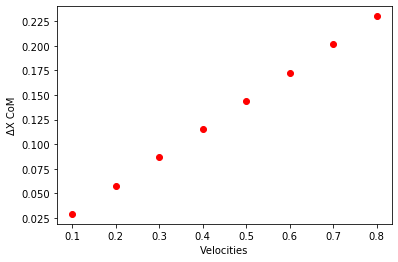

In [26]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394X CoM')
plt.show()

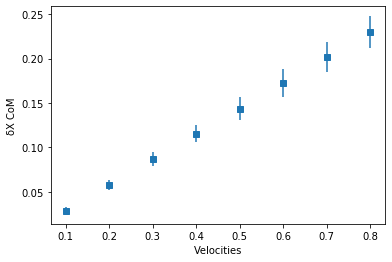

In [27]:
x = np.arange(0.1, 1.1, 0.1)
y = np.array([np.mean(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_fwd_CoM[np.where(np.isclose(X_motion_fwd_CoM[:, 0], velocity))[0], 0]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4X CoM')
plt.show()

### Left Plot

In [ ]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

In [ ]:
x = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
y = np.array([np.mean(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_left_CoM[np.where(np.isclose(X_motion_side_left_CoM[:, 1], velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Right Plot

In [ ]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9],
         [np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394Y CoM')
plt.show()

In [ ]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9])
y = np.array([np.mean(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
e = np.array([np.std(Y_motion_side_right_CoM[np.where(np.isclose(X_motion_side_right_CoM[:, 1], -velocity))[0], 1]) for velocity in np.arange(0.1, 1.0, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Clock Plot

In [ ]:
plt.plot([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0],
         [np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

In [ ]:
x = np.array([-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0])
y = np.array([np.mean(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_clock_CoM[np.where(np.isclose(X_motion_clock_CoM[:, 2], -velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

### Count Plot

In [ ]:
plt.plot(np.arange(0.1, 1.1, 0.1),
         [np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)], 
         'ro')
plt.xlabel('Velocities')
plt.ylabel('\u0394\u03B8 CoM')
plt.show()

In [ ]:
x = np.array(np.arange(0.1, 1.1, 0.1))
y = np.array([np.mean(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
e = np.array([np.std(Y_motion_count_CoM[np.where(np.isclose(X_motion_count_CoM[:, 2], velocity))[0], 2]) for velocity in np.arange(0.1, 1.1, 0.1)])
plt.errorbar(x, y, e, linestyle='None', marker='s')
plt.xlabel('Velocities')
plt.ylabel('\u03B4Y CoM')
plt.show()

## Forwad Check

In [ ]:
print(f"Min displacement: {min(Y_motion_fwd_CoM[:, 0])}. Max displacement: {max(Y_motion_fwd_CoM[:, 0])}")

## Clockwise Check

In [ ]:
print(f"Min displacement: {min(Y_motion_clock_CoM[:, 2])}. Max displacement: {max(Y_motion_clock_CoM[:, 2])}")

## Counter Check

In [ ]:
print(f"Min displacement: {min(Y_motion_count_CoM[:, 2])}. Max displacement: {max(Y_motion_count_CoM[:, 2])}")

## Left Check

In [ ]:
print(f"Min displacement: {min(Y_motion_side_left_CoM[:, 1])}. Max displacement: {max(Y_motion_side_left_CoM[:, 1])}")

## Right Check

In [ ]:
print(f"Min displacement: {min(Y_motion_side_right_CoM[:, 1])}. Max displacement: {max(Y_motion_side_right_CoM[:, 1])}")